# Introduction


**What?** K-fold CV on a CNN model for for the MNIST dataset



# Theoretical recal


- **K fold CV** is a technique used to evaluate the performance of your machine learning or deep learning model in a robust way.
- It splits the dataset into k parts/folds of approximately equal size. Each fold is chosen in turn for testing and the remaining parts for training.
- This process is repeated k times and then the performance is measured as the mean across all the test sets.



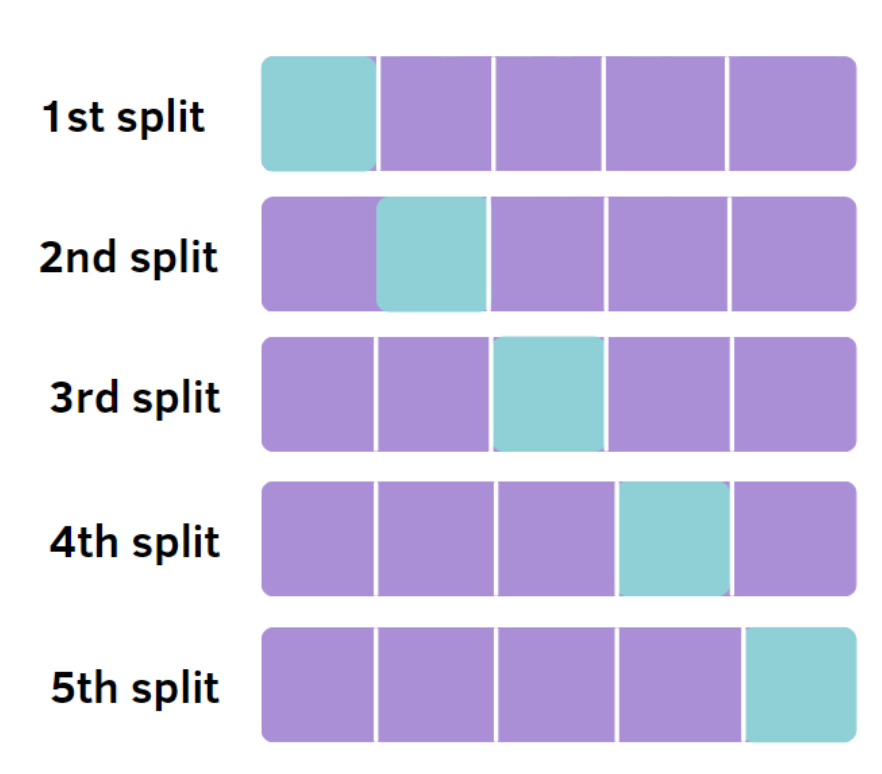

# Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

# Load the dataset


- The K Fold Cross Validation is used to evaluate the performance of the CNN model on the MNIST dataset. 
- This method is implemented using the sklearn library
- The model is trained using Pytorch.



In [2]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

# Building the model


- We define the Convolutional neural network architecture with 2 convolutional layers and one fully connected layer to classify the images in one of the ten categories. 
- We add two Dropout layers in the model to limit the risk of overfitting.



In [3]:
class ConvNet(nn.Module):
    def __init__(self,h1=96):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=0.5)   

        self.fc1 = nn.Linear(32 * 7 * 7, h1)
        self.drop2=nn.Dropout2d(p=0.1)

        self.fc2 = nn.Linear(h1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

# Split the dataset and create the CV folds


-  Moreover, we generate 10 folds using the Kfold function, where we have random splits and replicable results with random_state=42. 
- This divides the dataset into 9 parts for training and the remaining part for test.



In [4]:
train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)

dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs=10
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

# Defining train and validate calls

In [5]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

# Starting the k-fold validation process


- There are two main loops:
- **Loop#1:** we select the fold and therefore each train and and validation set
- **Loop#2:** For each fold select in Loop#1 we train the model
- If you are NOT running it on the GPU, it'll take roughly 30-45 minutes to complete



In [6]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = ConvNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')    

Fold 1
Epoch:1/10 AVG Training Loss:0.232 AVG Test Loss:0.078 AVG Training Acc 92.90 % AVG Test Acc 97.51 %
Epoch:2/10 AVG Training Loss:0.076 AVG Test Loss:0.046 AVG Training Acc 97.68 % AVG Test Acc 98.53 %
Epoch:3/10 AVG Training Loss:0.059 AVG Test Loss:0.047 AVG Training Acc 98.17 % AVG Test Acc 98.27 %
Epoch:4/10 AVG Training Loss:0.050 AVG Test Loss:0.038 AVG Training Acc 98.44 % AVG Test Acc 98.70 %
Epoch:5/10 AVG Training Loss:0.044 AVG Test Loss:0.031 AVG Training Acc 98.60 % AVG Test Acc 98.86 %
Epoch:6/10 AVG Training Loss:0.039 AVG Test Loss:0.035 AVG Training Acc 98.81 % AVG Test Acc 98.90 %
Epoch:7/10 AVG Training Loss:0.036 AVG Test Loss:0.034 AVG Training Acc 98.88 % AVG Test Acc 98.80 %
Epoch:8/10 AVG Training Loss:0.033 AVG Test Loss:0.037 AVG Training Acc 98.98 % AVG Test Acc 98.76 %
Epoch:9/10 AVG Training Loss:0.031 AVG Test Loss:0.034 AVG Training Acc 99.01 % AVG Test Acc 98.79 %
Epoch:10/10 AVG Training Loss:0.029 AVG Test Loss:0.025 AVG Training Acc 99.11 % AVG

Epoch:2/10 AVG Training Loss:0.079 AVG Test Loss:0.044 AVG Training Acc 97.60 % AVG Test Acc 98.66 %
Epoch:3/10 AVG Training Loss:0.061 AVG Test Loss:0.032 AVG Training Acc 98.18 % AVG Test Acc 99.00 %
Epoch:4/10 AVG Training Loss:0.050 AVG Test Loss:0.031 AVG Training Acc 98.46 % AVG Test Acc 99.10 %
Epoch:5/10 AVG Training Loss:0.046 AVG Test Loss:0.027 AVG Training Acc 98.61 % AVG Test Acc 99.19 %
Epoch:6/10 AVG Training Loss:0.040 AVG Test Loss:0.027 AVG Training Acc 98.77 % AVG Test Acc 99.30 %
Epoch:7/10 AVG Training Loss:0.037 AVG Test Loss:0.029 AVG Training Acc 98.81 % AVG Test Acc 99.10 %
Epoch:8/10 AVG Training Loss:0.034 AVG Test Loss:0.032 AVG Training Acc 98.92 % AVG Test Acc 99.14 %
Epoch:9/10 AVG Training Loss:0.032 AVG Test Loss:0.028 AVG Training Acc 99.05 % AVG Test Acc 99.19 %
Epoch:10/10 AVG Training Loss:0.030 AVG Test Loss:0.025 AVG Training Acc 99.03 % AVG Test Acc 99.19 %
Fold 10
Epoch:1/10 AVG Training Loss:0.222 AVG Test Loss:0.060 AVG Training Acc 93.08 % AV


- We can see the performances of the last two folds. The results seem pretty good, with 99% of accuracy in both training and test sets. Moreover, there is no evident difference between training and test accuracies, so we are not overfitting.
- To get a better idea of the generalisation power of the model we compute the average performances:
- We calculate the average score in every fold
- Once the average score is obtained for every fold, we calculate the average score over all the folds.



In [7]:
testl_f,tl_f,testa_f,ta_f = [],[],[],[]
k = 10
for f in range(1,k+1):

    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     

Performance of 10 fold cross validation
Average Training Loss: 0.064 	 Average Test Loss: 0.038 	 Average Training Acc: 98.00 	 Average Test Acc: 98.87


# Plotting the learning curves


- We can plot the average loss/accuracy curves across the ten cross-validation folds for CNN model.
- In the first 4 epochs, the accuracies increase very fastly, while the loss functions reach very low values. 
- Both the curves converge after 10 epochs.



In [8]:
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}

for i in range(num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_loss'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_loss'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['train_acc'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['test_acc'][i] for f in range(k)]))

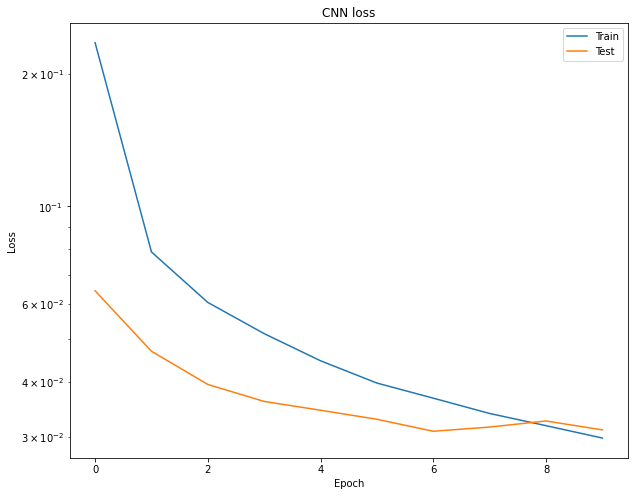

In [9]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
plt.title('CNN loss')
plt.show()

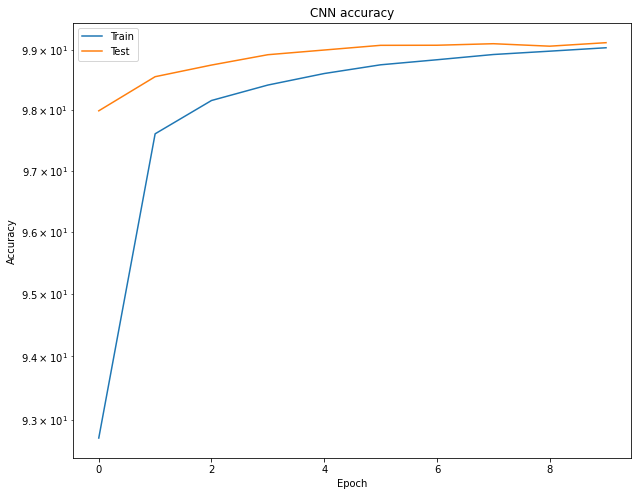

In [10]:
# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
plt.title('CNN accuracy')
plt.show()

# References


- https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f<br>



# Conclusions


- Keep in mind that CV is expensive. If your dataset is huge your do not really have to use CV.

